### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
from models.unet import UNet

random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [6]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [7]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [8]:
train_images = glob.glob('/data/segmentation/ISIC-2017/trainset/images/*')
train_labels = glob.glob('/data/segmentation/ISIC-2017/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/ISIC-2017/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/ISIC-2017/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외


train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)


custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))


custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

# train_images = sorted(train_images)
# train_labels = sorted(train_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)
        
# valid_images = sorted(valid_images)
# valid_labels = sorted(valid_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)

My custom training-dataset has 2000 elements
My custom valing-dataset has 150 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

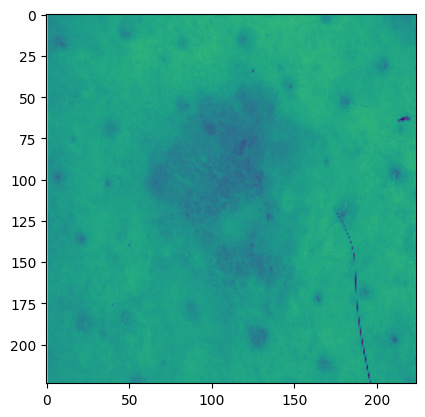

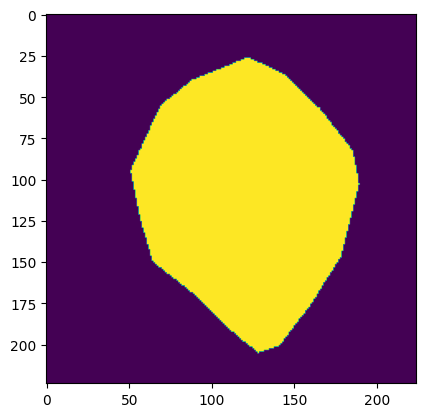

3픽셀의 평균값이라 색깔이 변경됨.


In [9]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [10]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [11]:
# Define variables for the training
epochs = 50
patience = 10
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [12]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = IoULoss()
# model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCELoss_baseline'

criterion = DiceBCELoss()
model_name = 'UNet_DiceBCELoss_baseline'


# 5. Training

In [13]:
def dice_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # (BATCH, 1, H, W) -> (BATCH, H, W)
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    dice = 2 * (intersection + SMOOTH) / (intersection + union + SMOOTH) # We smooth our devision to avoid 0/0

    return dice.mean()

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 0 of 50, Iter.: 250 of 250, Train Loss: 0.758465, IoU: 0.604965, Dice: 0.712806
 Epoch: 0 of 50, Iter.: 250 of 250, Valid Loss: 0.762813, IoU: 0.577074, Dice: 0.695058

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


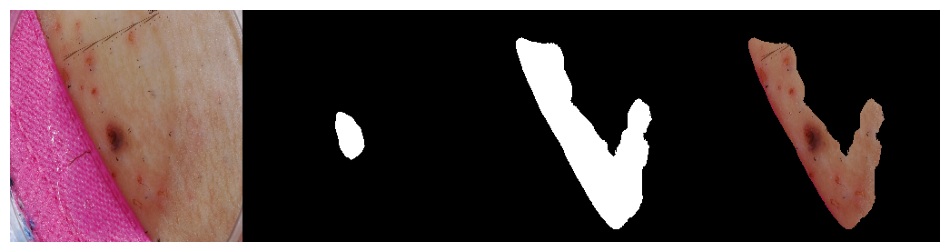

 Epoch: 1 of 50, Iter.: 250 of 250, Train Loss: 0.535797, IoU: 0.690550, Dice: 0.787695
 Epoch: 1 of 50, Iter.: 250 of 250, Valid Loss: 0.644874, IoU: 0.657110, Dice: 0.763861


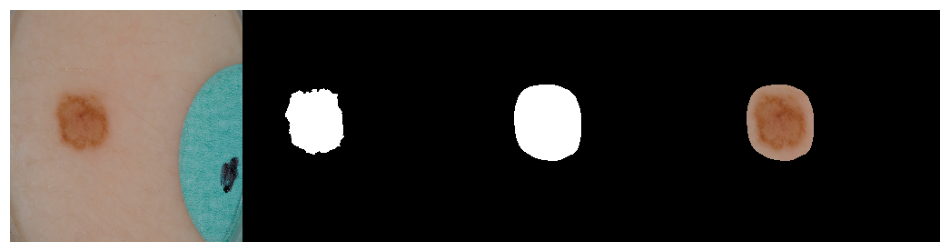

 Epoch: 2 of 50, Iter.: 250 of 250, Train Loss: 0.450599, IoU: 0.716202, Dice: 0.809998
 Epoch: 2 of 50, Iter.: 250 of 250, Valid Loss: 0.579449, IoU: 0.698434, Dice: 0.797191


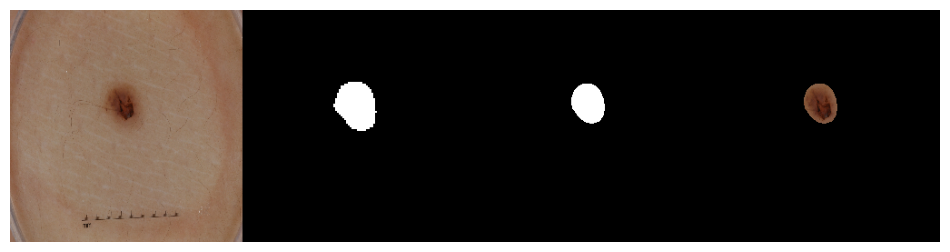

 Epoch: 3 of 50, Iter.: 250 of 250, Train Loss: 0.398913, IoU: 0.729475, Dice: 0.821021
 Epoch: 3 of 50, Iter.: 250 of 250, Valid Loss: 0.541161, IoU: 0.713873, Dice: 0.799992


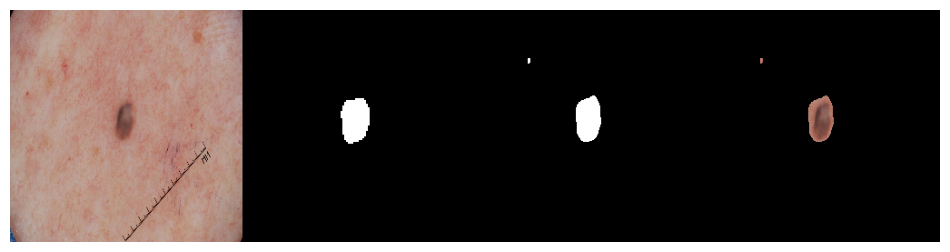

 Epoch: 4 of 50, Iter.: 250 of 250, Train Loss: 0.350371, IoU: 0.753804, Dice: 0.840183
 Epoch: 4 of 50, Iter.: 250 of 250, Valid Loss: 0.514290, IoU: 0.705309, Dice: 0.800808


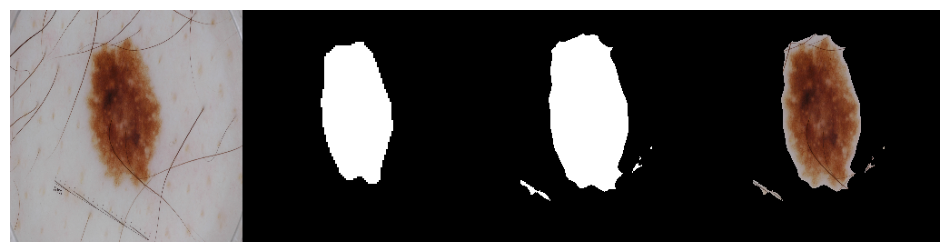

 Epoch: 5 of 50, Iter.: 250 of 250, Train Loss: 0.332035, IoU: 0.759948, Dice: 0.844684
 Epoch: 5 of 50, Iter.: 250 of 250, Valid Loss: 0.573061, IoU: 0.669396, Dice: 0.763447


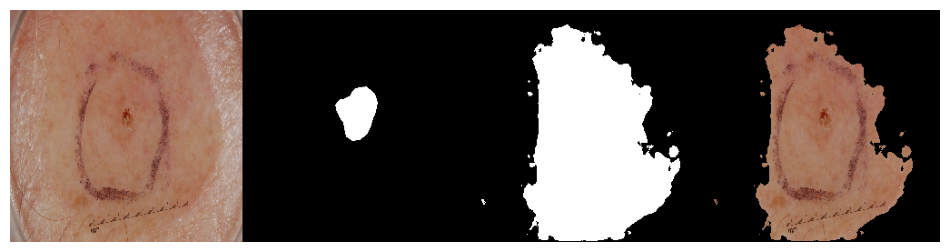

 Epoch: 6 of 50, Iter.: 250 of 250, Train Loss: 0.309865, IoU: 0.764879, Dice: 0.848928
 Epoch: 6 of 50, Iter.: 250 of 250, Valid Loss: 0.467708, IoU: 0.700516, Dice: 0.802504


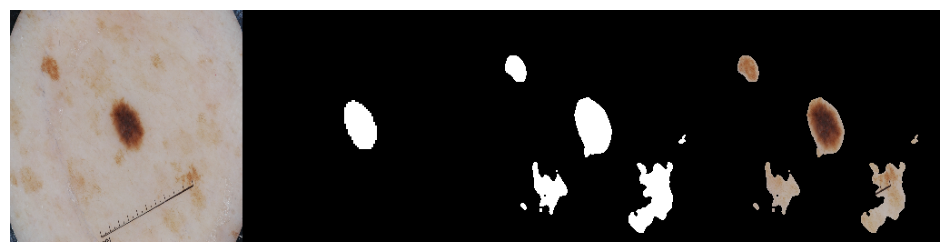

 Epoch: 7 of 50, Iter.: 250 of 250, Train Loss: 0.291910, IoU: 0.779364, Dice: 0.860286
 Epoch: 7 of 50, Iter.: 250 of 250, Valid Loss: 0.473998, IoU: 0.718115, Dice: 0.809945


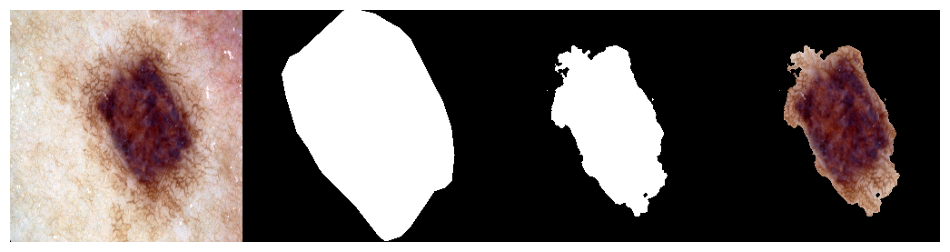

 Epoch: 8 of 50, Iter.: 250 of 250, Train Loss: 0.283069, IoU: 0.781632, Dice: 0.861537
 Epoch: 8 of 50, Iter.: 250 of 250, Valid Loss: 0.452012, IoU: 0.716119, Dice: 0.810733


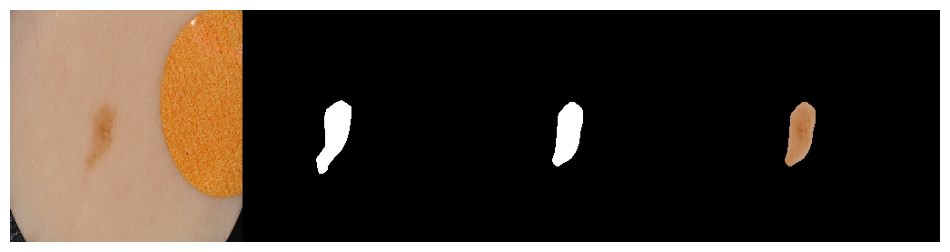

 Epoch: 9 of 50, Iter.: 250 of 250, Train Loss: 0.265121, IoU: 0.791574, Dice: 0.869975
 Epoch: 9 of 50, Iter.: 250 of 250, Valid Loss: 0.432055, IoU: 0.716387, Dice: 0.803778


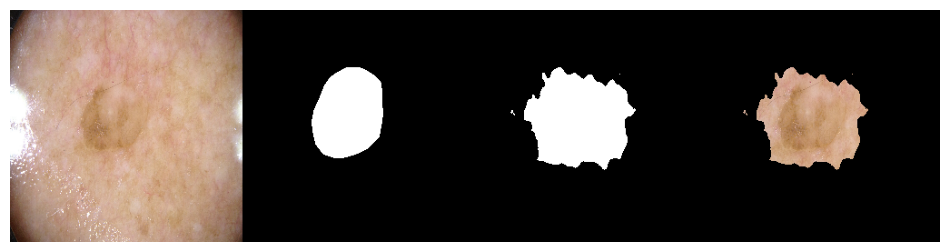

 Epoch: 10 of 50, Iter.: 250 of 250, Train Loss: 0.252270, IoU: 0.798249, Dice: 0.875437
 Epoch: 10 of 50, Iter.: 250 of 250, Valid Loss: 0.437723, IoU: 0.729698, Dice: 0.820343


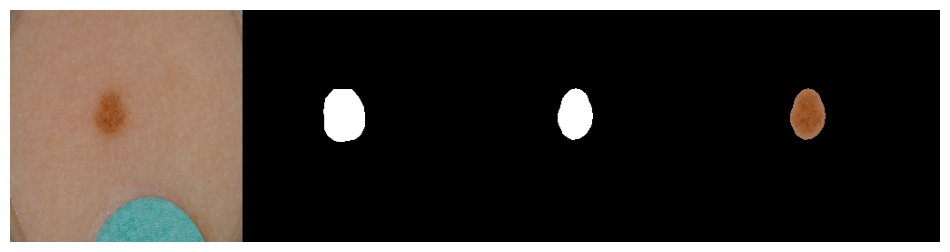

 Epoch: 11 of 50, Iter.: 250 of 250, Train Loss: 0.250152, IoU: 0.801708, Dice: 0.877281
 Epoch: 11 of 50, Iter.: 250 of 250, Valid Loss: 0.466735, IoU: 0.716739, Dice: 0.807570


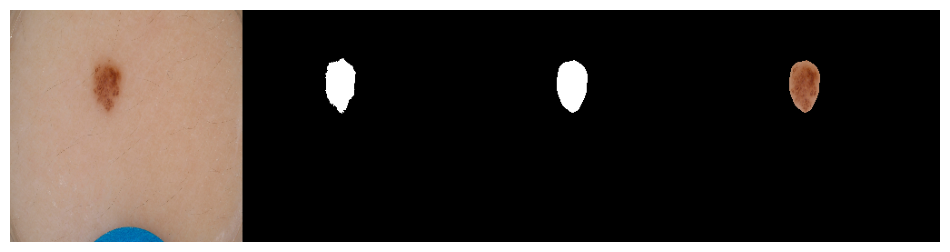

 Epoch: 12 of 50, Iter.: 250 of 250, Train Loss: 0.239340, IoU: 0.804293, Dice: 0.879946
 Epoch: 12 of 50, Iter.: 250 of 250, Valid Loss: 0.443595, IoU: 0.730644, Dice: 0.823434


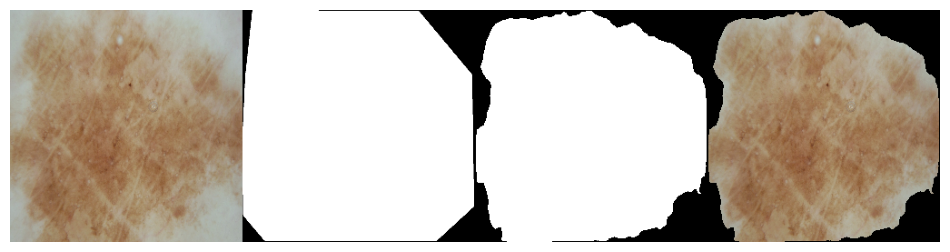

 Epoch: 13 of 50, Iter.: 250 of 250, Train Loss: 0.230042, IoU: 0.810183, Dice: 0.884174
 Epoch: 13 of 50, Iter.: 250 of 250, Valid Loss: 0.459903, IoU: 0.710301, Dice: 0.799294


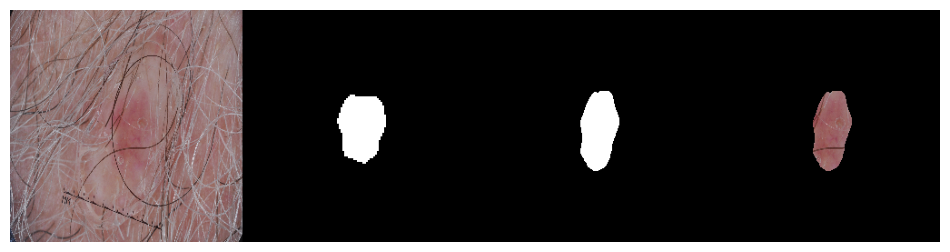

 Epoch: 14 of 50, Iter.: 250 of 250, Train Loss: 0.228172, IoU: 0.809416, Dice: 0.883227
 Epoch: 14 of 50, Iter.: 250 of 250, Valid Loss: 0.393771, IoU: 0.743087, Dice: 0.831701


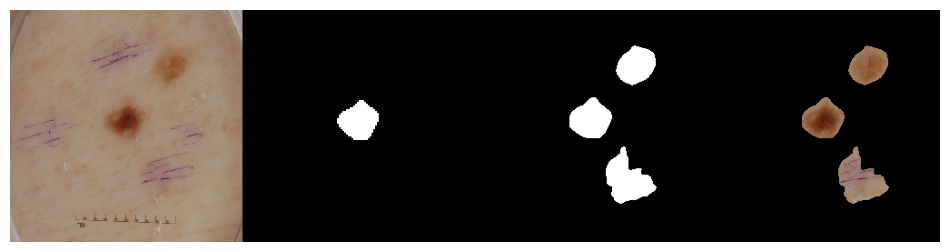

 Epoch: 15 of 50, Iter.: 250 of 250, Train Loss: 0.226692, IoU: 0.811031, Dice: 0.884035
 Epoch: 15 of 50, Iter.: 250 of 250, Valid Loss: 0.417467, IoU: 0.727378, Dice: 0.823693


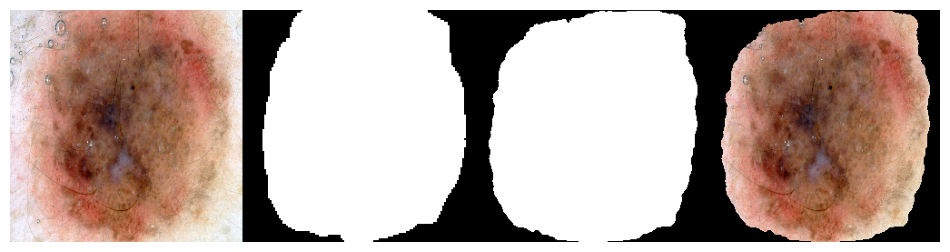

 Epoch: 16 of 50, Iter.: 250 of 250, Train Loss: 0.216175, IoU: 0.814131, Dice: 0.886868
 Epoch: 16 of 50, Iter.: 250 of 250, Valid Loss: 0.396227, IoU: 0.741333, Dice: 0.832909


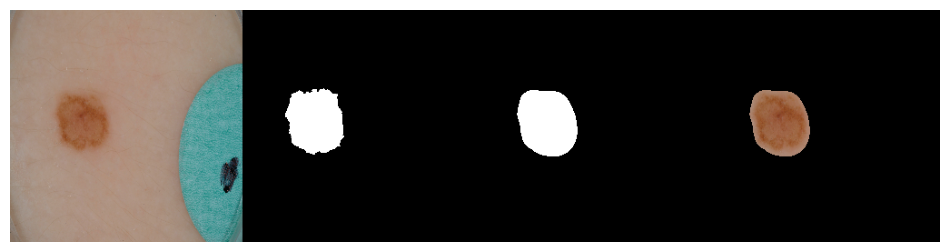

 Epoch: 17 of 50, Iter.: 250 of 250, Train Loss: 0.214032, IoU: 0.819286, Dice: 0.891376
 Epoch: 17 of 50, Iter.: 250 of 250, Valid Loss: 0.424221, IoU: 0.718090, Dice: 0.817481


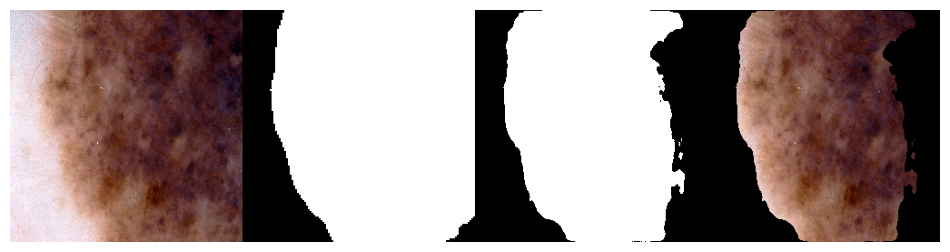

 Epoch: 18 of 50, Iter.: 250 of 250, Train Loss: 0.201649, IoU: 0.825020, Dice: 0.895680
 Epoch: 18 of 50, Iter.: 250 of 250, Valid Loss: 0.438902, IoU: 0.722319, Dice: 0.811741


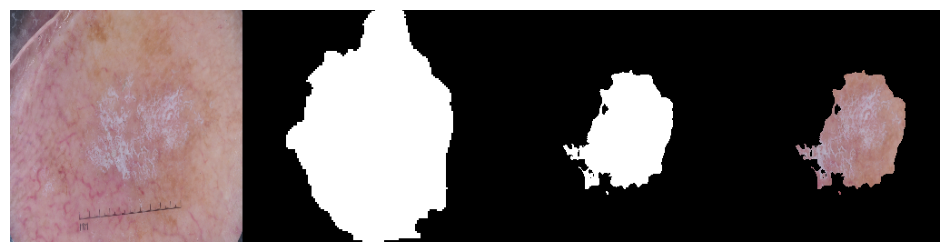

 Epoch: 19 of 50, Iter.: 250 of 250, Train Loss: 0.201297, IoU: 0.824899, Dice: 0.894936
 Epoch: 19 of 50, Iter.: 250 of 250, Valid Loss: 0.400434, IoU: 0.743704, Dice: 0.833452


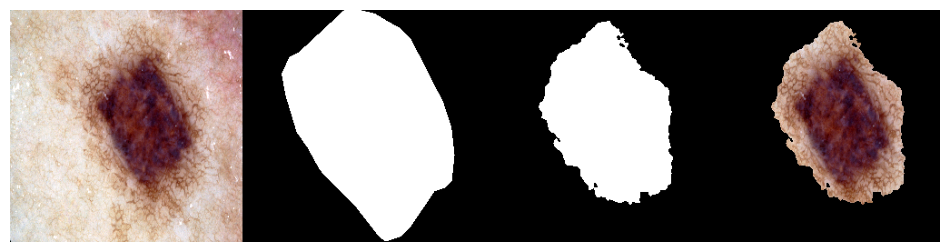

 Epoch: 20 of 50, Iter.: 250 of 250, Train Loss: 0.190423, IoU: 0.830624, Dice: 0.899423
 Epoch: 20 of 50, Iter.: 250 of 250, Valid Loss: 0.441910, IoU: 0.740114, Dice: 0.833979


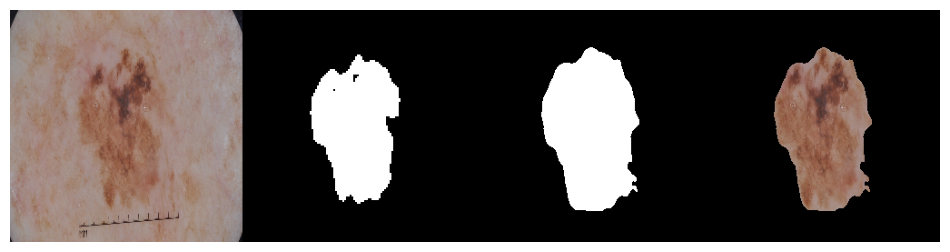

 Epoch: 21 of 50, Iter.: 250 of 250, Train Loss: 0.190240, IoU: 0.832153, Dice: 0.900859
 Epoch: 21 of 50, Iter.: 250 of 250, Valid Loss: 0.390751, IoU: 0.746184, Dice: 0.834150


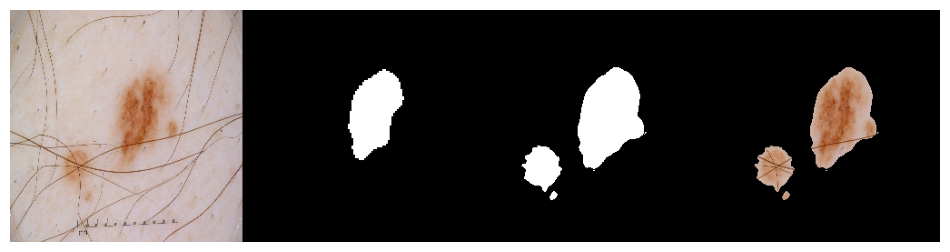

 Epoch: 22 of 50, Iter.: 250 of 250, Train Loss: 0.182214, IoU: 0.835915, Dice: 0.903076
 Epoch: 22 of 50, Iter.: 250 of 250, Valid Loss: 0.397554, IoU: 0.751924, Dice: 0.838207


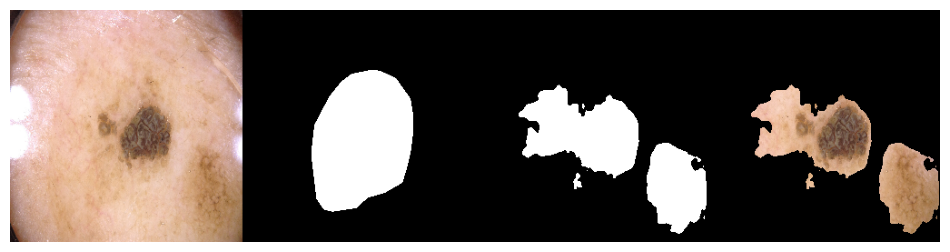

 Epoch: 23 of 50, Iter.: 250 of 250, Train Loss: 0.183589, IoU: 0.833971, Dice: 0.902418
 Epoch: 23 of 50, Iter.: 250 of 250, Valid Loss: 0.489052, IoU: 0.728353, Dice: 0.817931


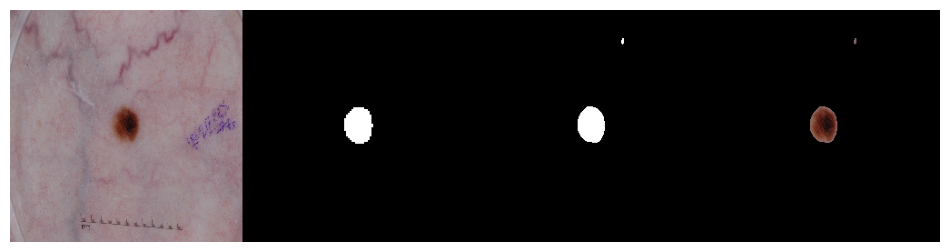

 Epoch: 24 of 50, Iter.: 250 of 250, Train Loss: 0.169590, IoU: 0.843178, Dice: 0.908598
 Epoch: 24 of 50, Iter.: 250 of 250, Valid Loss: 0.404092, IoU: 0.747695, Dice: 0.836139


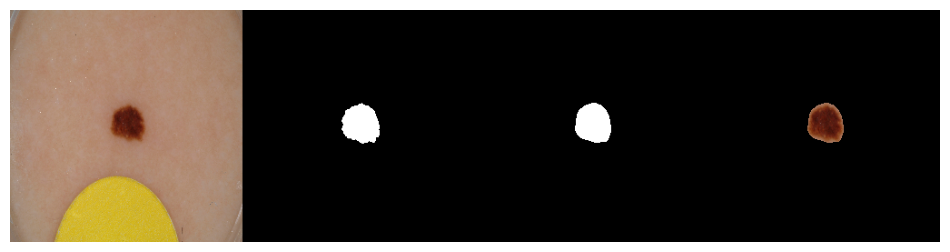

 Epoch: 25 of 50, Iter.: 250 of 250, Train Loss: 0.171040, IoU: 0.841204, Dice: 0.907206
 Epoch: 25 of 50, Iter.: 250 of 250, Valid Loss: 0.407109, IoU: 0.733934, Dice: 0.825391


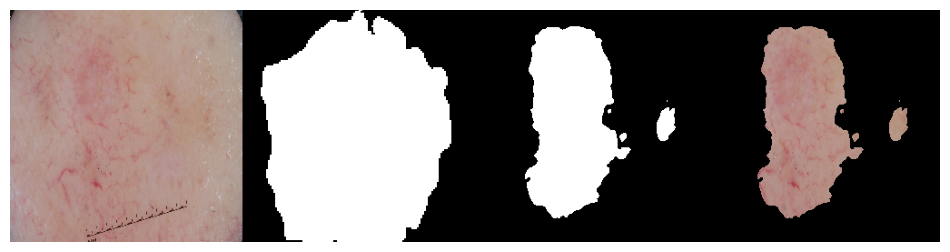

 Epoch: 26 of 50, Iter.: 250 of 250, Train Loss: 0.166143, IoU: 0.845466, Dice: 0.910356
 Epoch: 26 of 50, Iter.: 250 of 250, Valid Loss: 0.405166, IoU: 0.743747, Dice: 0.833705


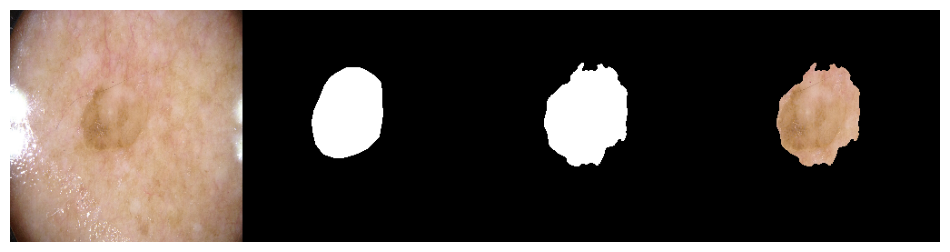

 Epoch: 27 of 50, Iter.: 250 of 250, Train Loss: 0.160848, IoU: 0.850518, Dice: 0.914484
 Epoch: 27 of 50, Iter.: 250 of 250, Valid Loss: 0.455255, IoU: 0.740445, Dice: 0.827173


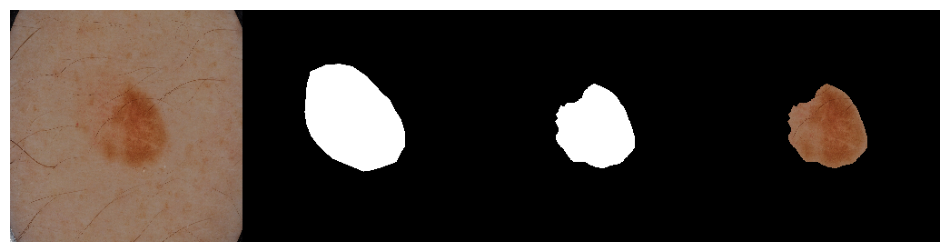

 Epoch: 28 of 50, Iter.: 250 of 250, Train Loss: 0.155465, IoU: 0.852282, Dice: 0.914955
 Epoch: 28 of 50, Iter.: 250 of 250, Valid Loss: 0.465535, IoU: 0.728648, Dice: 0.819373


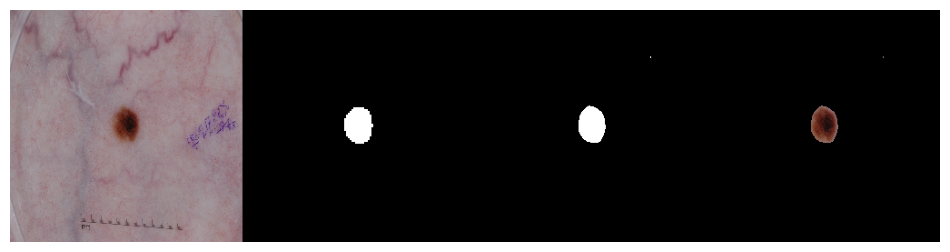

 Epoch: 29 of 50, Iter.: 250 of 250, Train Loss: 0.159132, IoU: 0.847324, Dice: 0.911593
 Epoch: 29 of 50, Iter.: 250 of 250, Valid Loss: 0.430733, IoU: 0.739692, Dice: 0.828799


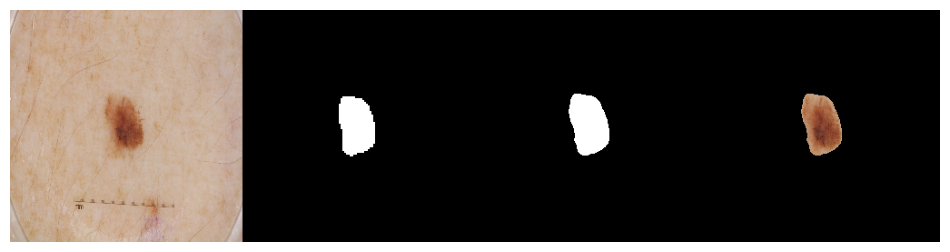

 Epoch: 30 of 50, Iter.: 250 of 250, Train Loss: 0.141779, IoU: 0.858486, Dice: 0.918914
 Epoch: 30 of 50, Iter.: 250 of 250, Valid Loss: 0.487615, IoU: 0.730798, Dice: 0.823141


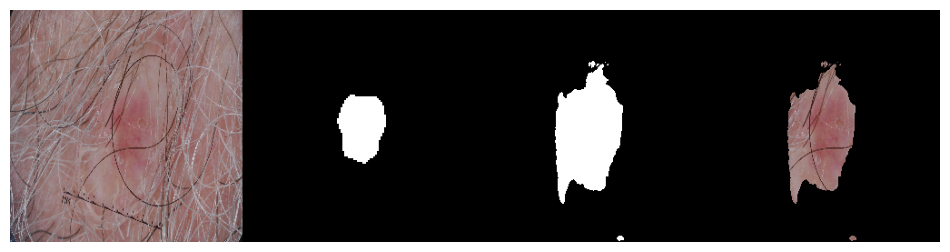

 Epoch: 31 of 50, Iter.: 250 of 250, Train Loss: 0.141992, IoU: 0.859161, Dice: 0.920174
 Epoch: 31 of 50, Iter.: 250 of 250, Valid Loss: 0.472735, IoU: 0.736663, Dice: 0.827141


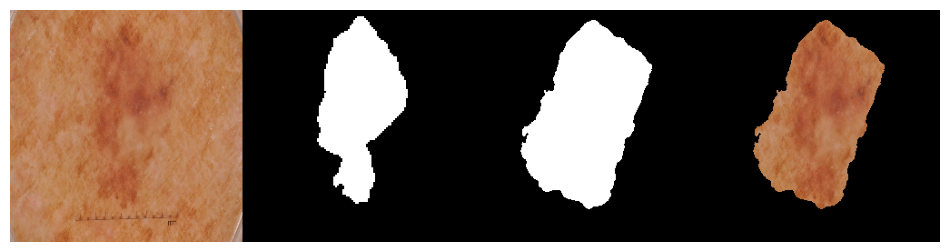

 Epoch: 32 of 50, Iter.: 250 of 250, Train Loss: 0.131013, IoU: 0.866362, Dice: 0.924810
 Epoch: 32 of 50, Iter.: 250 of 250, Valid Loss: 0.464024, IoU: 0.728034, Dice: 0.821696


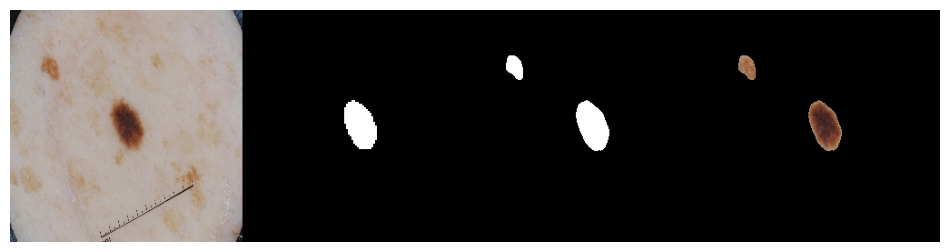

 Epoch: 33 of 50, Iter.: 250 of 250, Train Loss: 0.134401, IoU: 0.863559, Dice: 0.922641
 Epoch: 33 of 50, Iter.: 250 of 250, Valid Loss: 0.453106, IoU: 0.737354, Dice: 0.827745


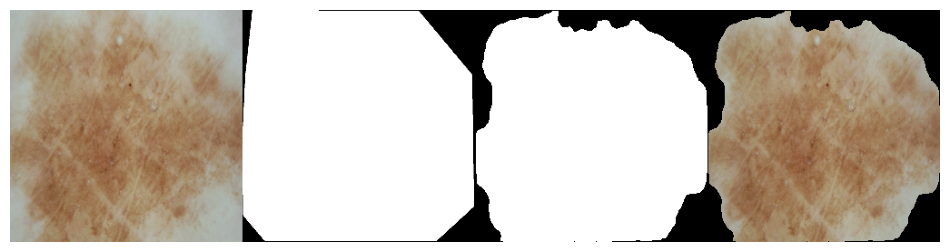


Early stopping. Target criteria has not improved for 10 epochs.

CPU times: user 14min 6s, sys: 5min 6s, total: 19min 13s
Wall time: 2h 37min 15s


In [14]:

%%time
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test
from ploting import plot_model_prediction

data_name = 'ISIC'

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch = -1
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

for epoch in range(epochs):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 0:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    if epoch+1 % 10 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
        for i, (metric, value) in enumerate(metrics.items()):
            axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=3)
            axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=3)
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Loss')
            axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
            axs[i].legend(loc='best')
        plt.show()
    
    lst_epoch_metric.append([round(epoch_train_loss,2), round(epoch_val_loss,2), round(epoch_train_iou,2), 
                             round(epoch_val_iou,2), round(epoch_train_dice,2), round(epoch_val_dice,2)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_iou = epoch if best_iou == epoch_val_iou else best_epoch_iou
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

# load once more and write all the losses down (othw can miss the last 10)
state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'metric_{model_name}_{data_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_IOU:0.7519, Best_DiceScore:0.8382


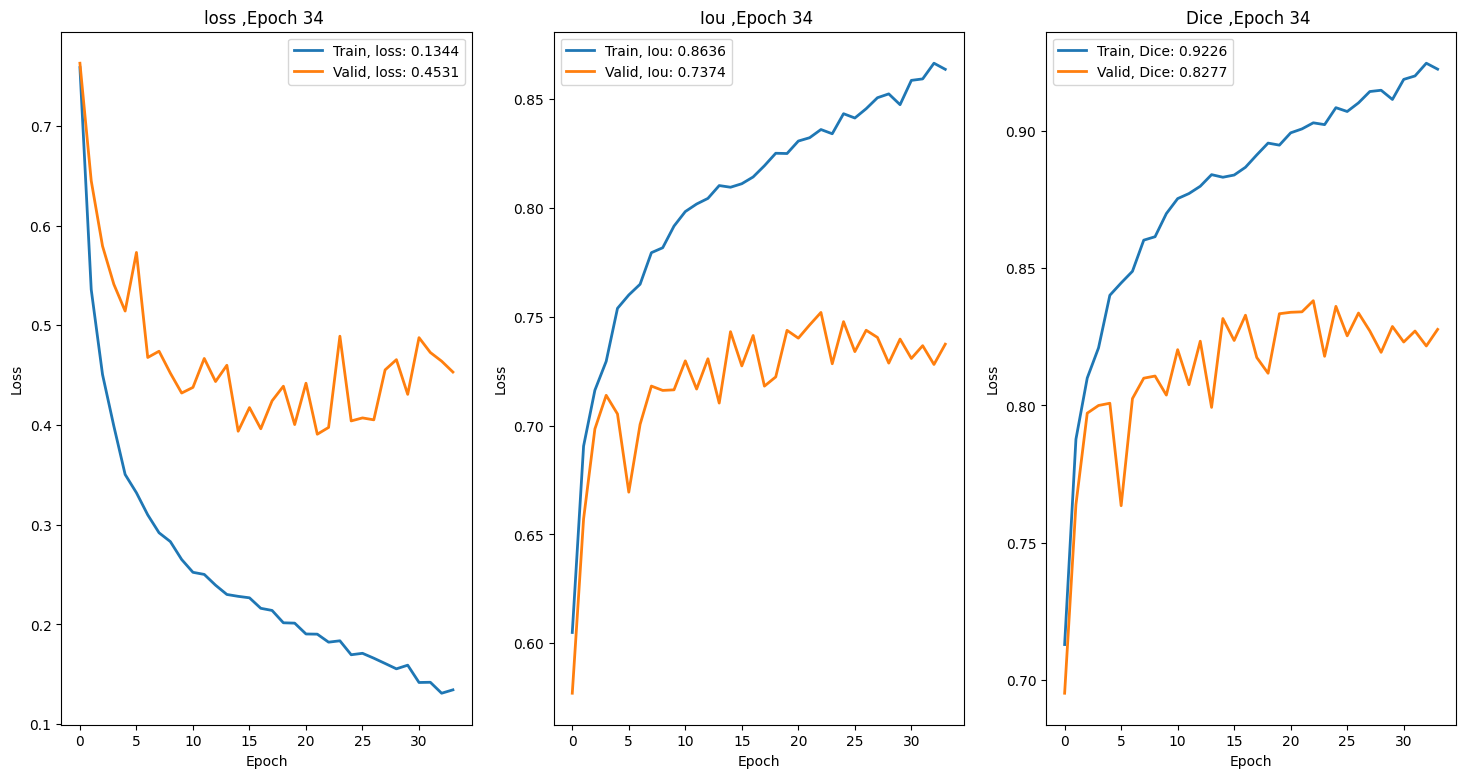

In [15]:
print(f'Validationset 기준 \nBest_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

# metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
#            'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
#            'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
    axs[i].legend(loc='best')
plt.show()